In [1]:
%load_ext autoreload
%autoreload 2

# автоматическое определение MDE (ML-критерии) и визуализация MDE
from ab_test_duration_calculator import *

# Если что-то не установлено, то прогнать вот это:
# pip install -r requirements.txt

In [2]:
df = pd.read_csv('example.csv')
df

,user_id,event_date,spend,spend_2,category_1,category_2,flg
0,1153986717,2024-03-10,96.771667,0.000000,a,b,0
1,1449117000192,2024-02-08,23.412500,0.000000,a,b,0
2,1106869893,2024-04-25,257.537500,0.000000,a,b,0
3,827256751191,2024-01-27,117.062500,0.000000,a,b,0
4,1106869893,2024-02-07,46.825000,0.000000,a,b,0
...,...,...,...,...,...,...,...
245266,2133577500207,2024-02-19,25.207458,25.207458,a,b,0
245267,3377144250447,2024-01-10,2573.814167,0.000000,f,c,0
245268,226161750033,2024-02-26,427.668333,0.000000,a,a,0
245269,2133577500207,2024-02-24,11.144350,11.144350,a,b,0


Итак, датасет для планирования эксперимента имеет следующую форму. В колонке `user_id` содержится юнит - единица наблюдения (в нашем случае - конкретный уникальный user_id), `event_date` - дата расчета метрики (в формате datetime), а дальше ряд метрик, для которых мы высчитываем MDE, а также ряд физических характеристик и прочих признаков, которые будут использоваться в ML-моделировании для снижения дисперсии основных метрик.

В нашем случае мы имеем два категориальных признака `category_1`, `category_2` и один булевый признак `flg` (будем рассматривать как численный признак).

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245271 entries, 0 to 245270
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     245271 non-null  int64  
 1   event_date  245271 non-null  object 
 2   spend       245271 non-null  float64
 3   spend_2     245271 non-null  float64
 4   category_1  245271 non-null  object 
 5   category_2  245271 non-null  object 
 6   flg         245271 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 13.1+ MB


Подготовим корректные типы данных. `event_date` должен быть типа datetime, проверяем, что категориальные признаки типа str или object, а численные признаки - численного типа.

In [4]:
df['event_date'] = pd.to_datetime(df['event_date'])

Попробуем рассчитать MDE для метрик `spend` и `spend_2`, отражающие с разных сторон траты конкрентного юзера (user_id) на конкретную дату (event_date). Для этого применим стандартные методы оценки уровня MDE, а также методы, основанные на ML-моделировании.

Для этого нам необходимо определить `start_date` - дата начала эксперимента и исследуемые метрики в `metric_range`.

In [5]:
start_date = '2024-04-01'
metric_range = ['spend', 'spend_2']

#### Способ 1. Статистический способ расчета MDE (без использования дополнительных ковариат и ML-критериев)

Processing metrics:   0%|          | 0/2 [00:00<?, ?it/s]

Processing durations for metric spend:   0%|          | 0/6 [00:00<?, ?it/s]

Processing durations for metric spend_2:   0%|          | 0/6 [00:00<?, ?it/s]

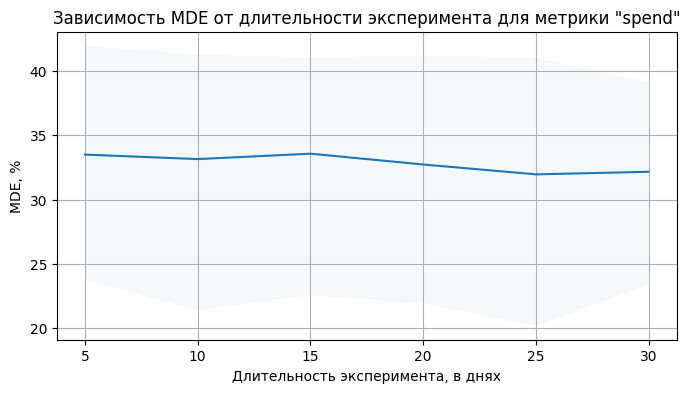

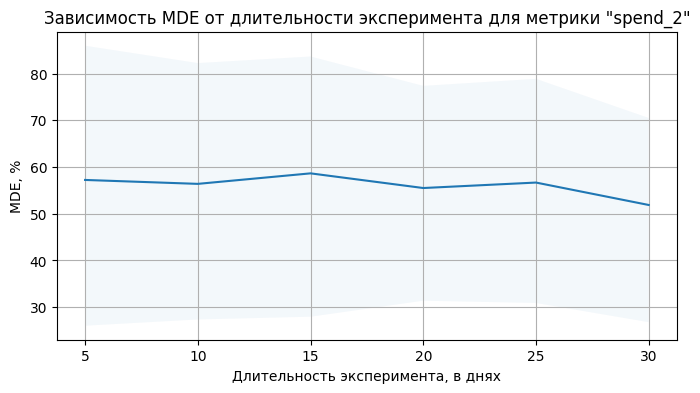

,mde,left_mde,right_mde,metric,total_manager_cnt,test_group,duration,pre_duration
0,33.50,23.738035,41.983602,spend,4764,2382,5,None
1,33.15,21.385829,41.283549,spend,6628,3314,10,None
2,33.57,22.541064,41.076459,spend,8158,4079,15,None
3,32.73,21.904977,41.210340,spend,9328,4664,20,None
4,31.96,20.165397,41.059763,spend,10579,5289,25,None


In [6]:
mde_results_usual = MDE_relative_ttest_calc(data=df,
                                            metric_range=metric_range,
                                            start_date=start_date)

mde_results_usual.head()

Функция `MDE_relative_ttest_calc` возвращает относительный MDE (выраженный в %), при этом учитывает только историческую дисперсию метрики на экспериментальном периоде. Кроме графика, `MDE_relative_ttest_calc` возвращает датасет с уровнями MDE для каждой метрики и для любой длительности эксперимента, который можно использовать для дополнительной аналитики. Так, мы видим, что метрика `spend` и `spend_2` крайне шумные и что несмотря на увеличение юзеров, из-за увеличения дисперсии метрики MDE остается примерно на одном уровне, причем крайне высоком. Вряд ли какие-то дополнительные улучшения в сервисе позволит повысить выручку на более, чем 30% :).

Поэтому для того, чтоб проводить эксперименты на крайне шумных метриках можно воспользоваться следующий методологией. Обычно ищут какие-то прокси-метрики, которые связаны с целевой метрикой, но менее шумные. Однако далее встает вопрос - как изменения в прокси-метрике отнести к изменениям целевой метрике и в какой величине? Поэтому прежде чем смотреть на прокси-метрики, можно попробовать применить методы снижения дисперсии для целевой, шумной метрики и посмотреть, удастся ли MDE снизить на приемлемый для нас уровень.

#### Способ 2. Расчет MDE с помощью применения дополнительных ковариат (CUPED) и ML-критериев (CUPAC)


Пусть дата начала эксперимента - 1 апреля, длительность эксперимента - 1 месяц. Тогда в качестве ковариаты для CUPED можно использовать значение метрики в предэкспериментальном периоде, например, взять выручку юзеров в мае и попробовать предсказать часть дисперсии метрики в экспериментальном периоде.

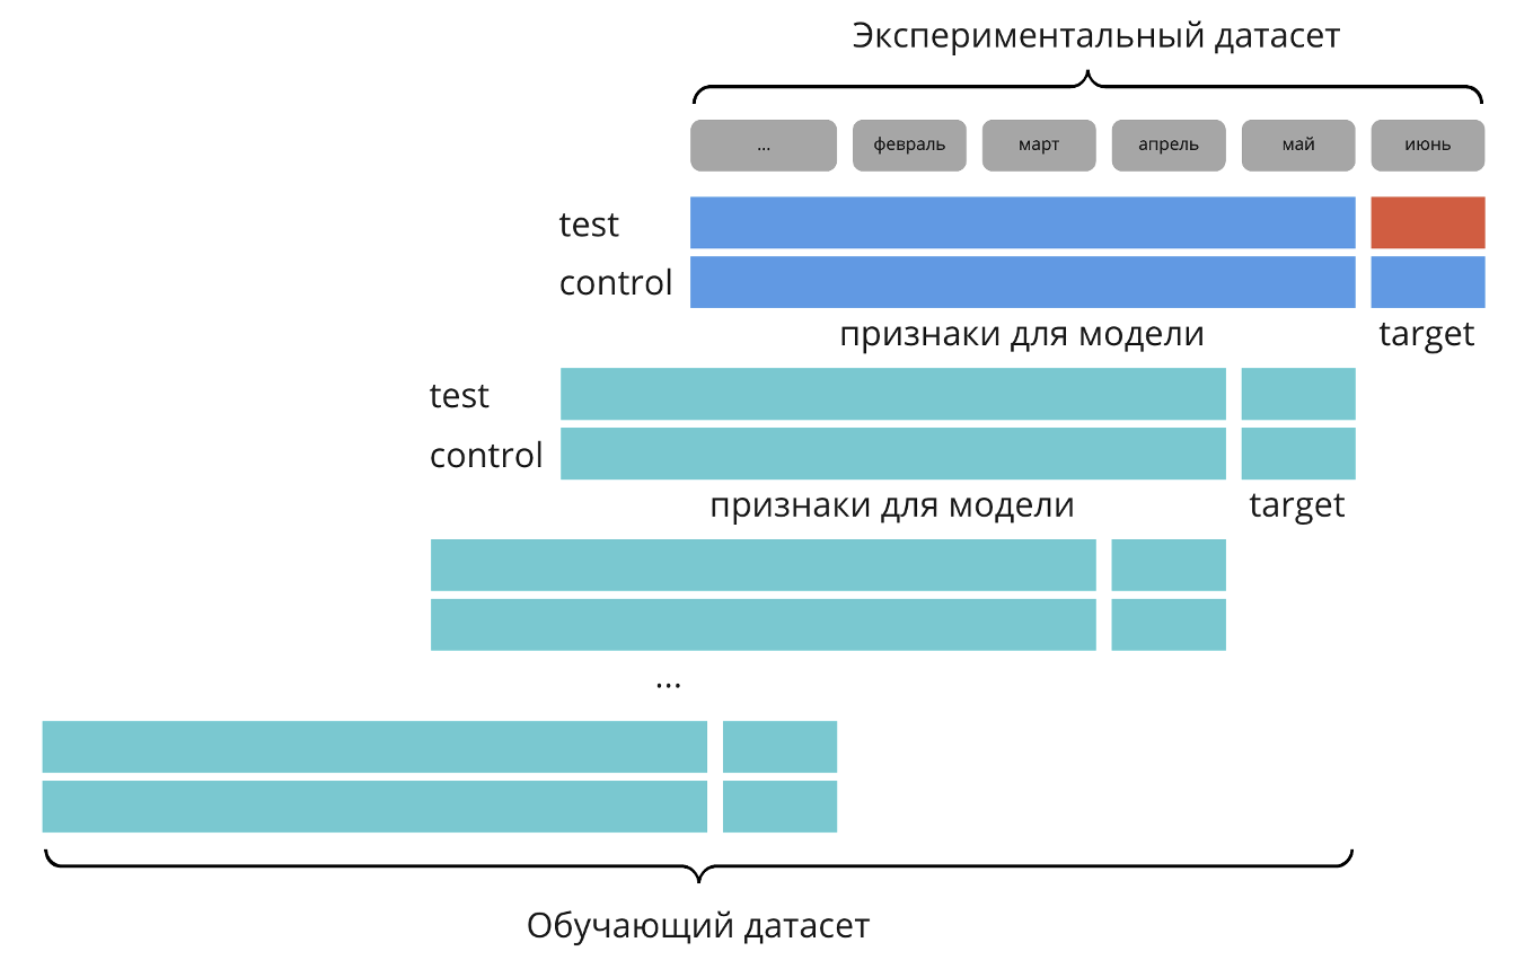

Нам нужна функция для сбора обучающего датасета. Соберем обучающий датасет с января по апрель 2024 года. То есть модель будет предсказывать метрику с января по февраль, с февраля по март, с марта по апрель. Поскольку это одни и те же юзеры, то добавим ковариату времени. Кстати, если взять больший временной период, можно будет учесть влияние сезонности.

#### 2.1 CUPED (в качестве ковариаты используется значение метрика в предпериоде, без доп. ковариат)

То есть тут полный аналог линейной регрессии.

Processing metrics:   0%|          | 0/2 [00:00<?, ?it/s]

Processing durations for metric spend:   0%|          | 0/6 [00:00<?, ?it/s]

Processing durations for metric spend_2:   0%|          | 0/6 [00:00<?, ?it/s]

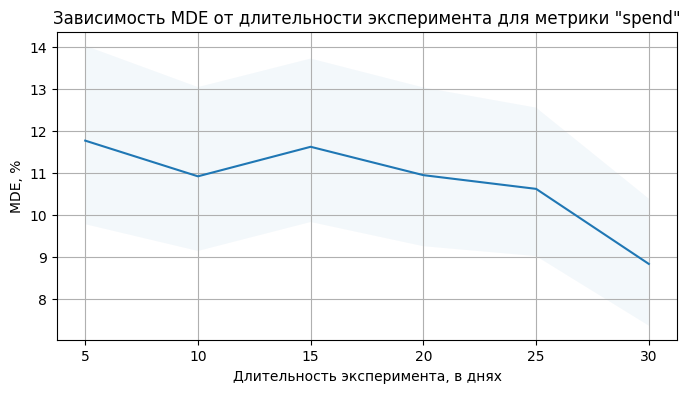

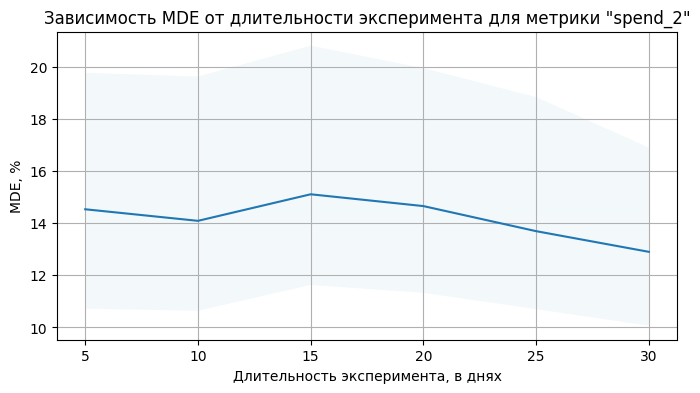

,mde,left_mde,right_mde,metric,total_unit_cnt,test_group,duration,pre_duration,bad_cnt_pct,FPR_test,uniform_pvalues
0,11.764017,9.773776,14.024216,spend,8054,4027,5,10,5.0,True,True
1,10.913905,9.136177,13.039032,spend,9404,4702,10,10,7.0,True,True
2,11.617206,9.825767,13.718548,spend,10607,5303,15,10,3.0,True,True
3,10.941840,9.249132,13.030048,spend,11544,5772,20,10,6.0,True,True
4,10.614884,9.013066,12.550006,spend,12546,6273,25,10,4.0,True,False


In [7]:
mde_results_cuped = MDE_relative_cuped_calc(data=df,
                                             metric_range=metric_range,
                                             start_date=start_date,
                                             ML_flg=False)

mde_results_cuped.head()

#### 2.2 CUPAC (используется значение метрики в предпериоде + набор доп. ковариат, с возможностью любых ML-моделей)

Processing metrics:   0%|          | 0/2 [00:00<?, ?it/s]

Processing durations for metric spend:   0%|          | 0/6 [00:00<?, ?it/s]

Метрика spend, длительность 5 дней, R-squared (на тесте): 0.85
Метрика spend, длительность 10 дней, R-squared (на тесте): 0.89
Метрика spend, длительность 15 дней, R-squared (на тесте): 0.90
Метрика spend, длительность 20 дней, R-squared (на тесте): 0.91
Метрика spend, длительность 25 дней, R-squared (на тесте): 0.84
Метрика spend, длительность 30 дней, R-squared (на тесте): 0.91


Processing durations for metric spend_2:   0%|          | 0/6 [00:00<?, ?it/s]

Метрика spend_2, длительность 5 дней, R-squared (на тесте): 0.91
Метрика spend_2, длительность 10 дней, R-squared (на тесте): 0.92
Метрика spend_2, длительность 15 дней, R-squared (на тесте): 0.91
Метрика spend_2, длительность 20 дней, R-squared (на тесте): 0.91
Метрика spend_2, длительность 25 дней, R-squared (на тесте): 0.81
Метрика spend_2, длительность 30 дней, R-squared (на тесте): 0.90


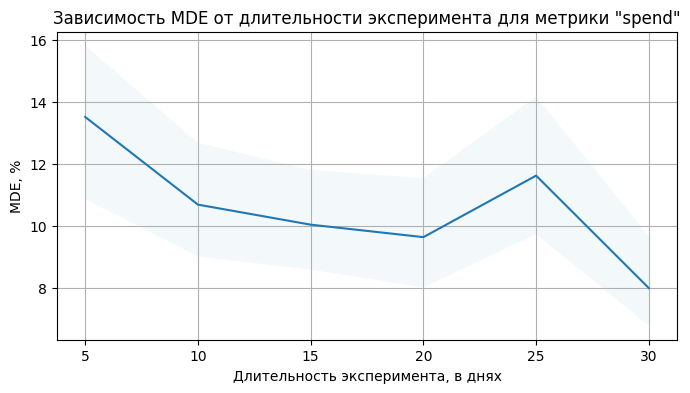

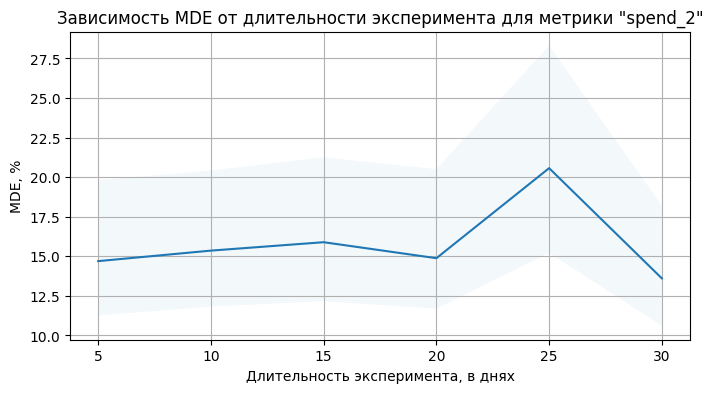

,mde,left_mde,right_mde,metric,total_unit_cnt,test_group,duration,pre_duration,bad_cnt_pct,FPR_test,uniform_pvalues
0,13.525423,10.887004,15.822990,spend,4402,2201,5,10,7.0,True,True
1,10.698122,9.024393,12.690597,spend,6284,3142,10,10,8.0,True,False
2,10.052004,8.603380,11.817180,spend,7838,3919,15,10,7.0,True,True
3,9.649447,8.028978,11.548004,spend,9161,4580,20,10,4.0,True,True
4,11.633438,9.750633,14.185384,spend,10353,5176,25,10,6.0,True,True


In [8]:
model_params = {'model': Ridge(), 
                'param_grid': {'alpha': [0.1, 1, 10]},
                'categorical_columns': ['category_1', 'category_2'], 
                'numerical_columns': ['flg'],
                'verbose': True}

mde_results_cupac = MDE_relative_cuped_calc(data=df,
                                             metric_range=metric_range,
                                             start_date=start_date,
                                             ML_flg=True,
                                             model_params=model_params)

mde_results_cupac.head()

In [10]:
mde_results_cupac

,mde,left_mde,right_mde,metric,total_unit_cnt,test_group,duration,pre_duration,bad_cnt_pct,FPR_test,uniform_pvalues
0,13.525423,10.887004,15.822990,spend,4402,2201,5,10,7.0,True,True
1,10.698122,9.024393,12.690597,spend,6284,3142,10,10,8.0,True,False
2,10.052004,8.603380,11.817180,spend,7838,3919,15,10,7.0,True,True
3,9.649447,8.028978,11.548004,spend,9161,4580,20,10,4.0,True,True
4,11.633438,9.750633,14.185384,spend,10353,5176,25,10,6.0,True,True
5,8.004811,6.792541,9.669272,spend,11270,5635,30,10,13.0,False,False
6,14.692622,11.263767,19.795874,spend_2,4402,2201,5,10,5.0,True,True
7,15.356315,11.823078,20.416678,spend_2,6284,3142,10,10,10.0,False,True
8,15.887398,12.158225,21.248343,spend_2,7838,3919,15,10,6.0,True,True
9,14.877402,11.694705,20.503155,spend_2,9161,4580,20,10,9.0,True,True


### Сравнительный анализ методов

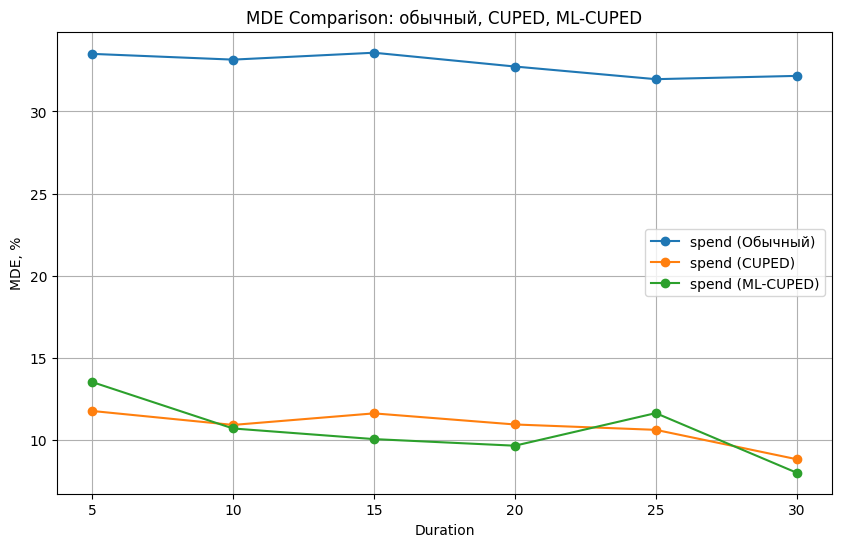

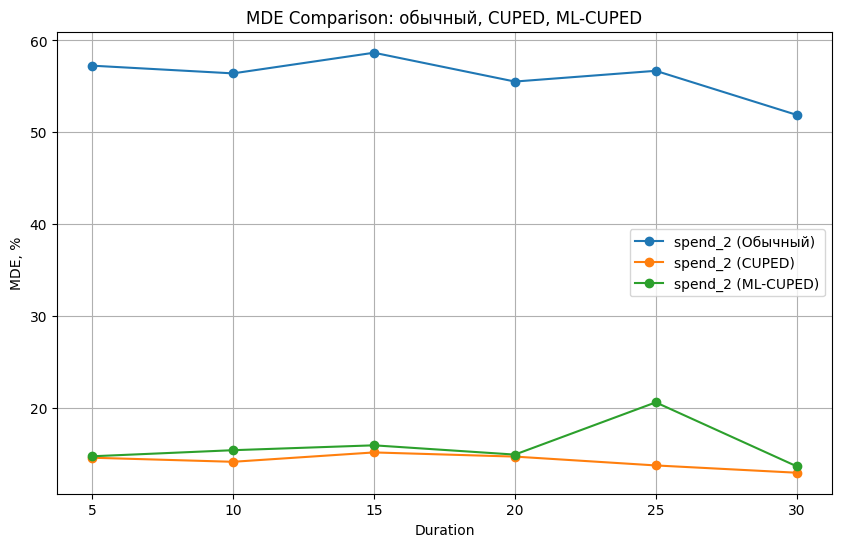

In [9]:
for metric in metric_range:
    
    plt.figure(figsize=(10, 6))
    
    # Данные для обычного расчета MDE
    mde_results_usual_plot = mde_results_usual[mde_results_usual['metric'] == metric]
    plt.plot(mde_results_usual_plot['duration'], mde_results_usual_plot['mde'],
             marker='o', label=f'{metric} (Обычный)')
        
    # Данные для CUPED
    mde_results_cuped_plot = mde_results_cuped[mde_results_cuped['metric'] == metric]
    plt.plot(mde_results_cuped_plot['duration'], mde_results_cuped_plot['mde'],
             marker='o', label=f'{metric} (CUPED)')
    
    # Данные для CUPAC
    mde_results_cupac_plot = mde_results_cupac[mde_results_cupac['metric'] == metric]
    plt.plot(mde_results_cupac_plot['duration'], mde_results_cupac_plot['mde'],
             marker='o', label=f'{metric} (ML-CUPED)')
        
    plt.xlabel('Duration')
    plt.ylabel('MDE, %')
    plt.title('MDE Comparison: обычный, CUPED, ML-CUPED')
    plt.legend()
    plt.grid(True)
    plt.show()

**Вывод**: видим, что обычный расчет MDE значительным образом уступает методам, при которых мы используем дополнительные ковариаты. При этом мы видим, что использование лишь ковариаты о значении метрики в экспериментальном метрике дает огромный буст с точки зрения снижения дисперсии метрики и снижения продолжительности экспериментов. На самом деле, it's up to you, найти любые другие признаки, которые могут объяснять существенную долю дисперсии метрики для снижения MDE и увеличению скорости проведения экспериментов. Этот AB framework для планирования экспериментов предоставляет все возможности.